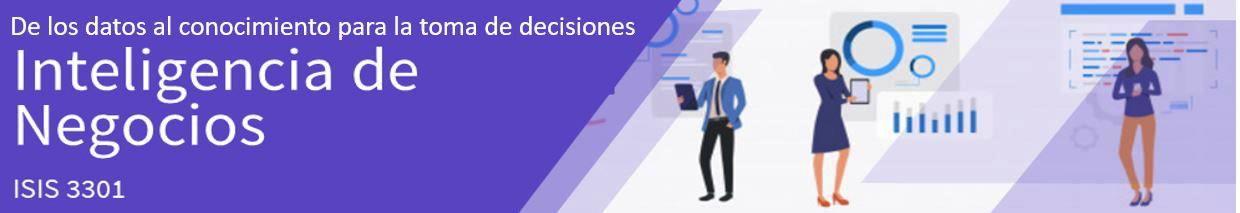

# Proyecto analítica de texto: Etapa 1. Construcción de modelos de analítica de textos

# Caso

Este proyecto tiene comentarios de películas en español, que deben ser clasificadas en las categorías de positivo, negativo.

Jesús Jimenez (202020431), Juan Camilo Bonet (202022466) y Thais Tamaio (202022213).

# Los datos

In [1]:
import string

import numpy as np
import pandas as pd

import re
import joblib
from joblib import Parallel, delayed

from langdetect import detect
from unidecode import unidecode
import unicodedata

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words

from num2words import num2words

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thaistamaio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/thaistamaio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/thaistamaio/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))
nltk.download('words')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package words to
[nltk_data]     /Users/thaistamaio/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
def tokenizer(text):
    return word_tokenize(text)

# 1. Entendimiento de los datos

## 1.1 Carga de los datos

Primero, se cargan los datos:

In [5]:
movies_df = pd.read_csv('./data/MovieReviews.csv', sep = ',')

In [6]:
movies_df.shape

(5000, 3)

## 1.2 Descripción de los datos

Se muestran algunos ejemplos de los datos que pueden encontrarse en MovieReviews.csv:

In [7]:
movies_df.sample(5)

,Unnamed: 0,review_es,sentimiento
424,424,"Con Oliver Hardy Bedviled por el sonido de cuernos, campanas, teléfonos y trombones, su médico Finlayson aconseja la paz y la tranquilidad y una dieta de leche de cabra. Socio Stan Laurel se le ocurren una excelente solución, viviendo en un barco atracado, por lo que el aire de mar de sal puede ayudar a Ollie a obtener todo lo que necesita. Es una gran premisa para todos los hijinks de la CAP MAD, ya que el barco se establece a la deriva por la cabra hambrienta, y un convicto escapado (Richard Cramer) se estanca por el paseo. Tengo una patada de todos los gags en la película. , comenzando con ese signo en la fábrica de pruebas de cuerno: 'Silencio Mientras los hombres están trabajando'. La historia temprana en el apartamento de niños cuenta con una serie de contratiempos de plomería y electrodomésticos mezclados, con Stan haciendo un plátano dentro de un bit de plátano. Laurel tiene un par de excelentes líneas en la imagen, como ""Debemos haber sido desconectadas"", pero el que me hizo rodar fue su respuesta al criminal a bordo del barco: ""La autoservicio es la última ley de los promedios"". ¡Precisamente! No soy tan grande un estudiante de las películas de Laurel y Hardy tantas en esta junta, todo lo que sé es que los disfruté como un niño y los encuentro como entretenidos hoy en día, ya que estaban de vuelta en mi juventud. En ese recuento, ""SAPS en el mar"" proporciona una hora decente de diversión hornophóbica, bien en su camino a Horcomanía.",positivo
3061,3061,"Alquilé esta película cuando mi novia estaba lejos, con la esperanza de ver una acción militar / especialista seria. Después de ver esta ""película"", estaba tan aterrorizada y horrorizada y enferma de la calidad de todo en esta película que estaba lista paraDestruye el disco alquilado con un lanzamiento de llamas.Por suerte no pude encontrar uno.He visto muchas películas malas.Pero esto no es malo, es la basura total y ni siquiera merece ser contabilizada como una película aquí en IMDB. Siento la pena por las personas que han estado involucradas en la realización de esta desgracia total.Espero que vaya a algunos Oscar, aunque: d.",negativo
3252,3252,"Ok ... esta película podría haber sido tan buena! Todas las generaciones han sido expuestas a Thunderbirds y han venido a amarlo y esta película tuvo algunas de las características que uno buscaría en una buena película Thunderbirds. La artesanía a sí mismos y Tracey Island fueron transferidos de manera realista a la pantalla grande, mientras aún conservamos los diseños con los que nos enamoramos. Sophia Miles fue, simplemente, fantástica, como Lady P y Bill Paxton, mientras que no exactamente quiénes prevé a Jeff Tracey, fue lo suficientemente sólido ... pero luego los adultos fueron sacados de la ecuación y nos pidieron que creíamos de 8 años. Podría volar 200 máquinas de toneladas. No es tanto el hecho de que la película se centró en los niños que me hicieron sentir que las franas de Jonathon me estaban abofeteando con un pez mojado y se ríe de mi dinero duramente ganado que se gastó en la película, fue el hecho. Que Alan Tracey fue tan desagradable en la película y que parecía ser tan capaz de volar las máquinas, así como a sus hermanos ... que eran al menos 19/20. En serio, estas son algunas máquinas simples bonitas para usar si este es el caso. La película no parecía saber si quería ser serio o lejano. Intentó pagar homenaje mientras se satira y generalmente se cayó en su cara. 3/10 (2 para las máquinas, 1 para Lady P)",negativo
4676,4676,"El escritor y director Robert Downey, Sr., un pionero del movimiento de cine metro en la década de 1960, satirizó el mundo de la publicidad de Nueva York Madison Avenue con su comedia de vanguardia ""PUTNEY SHAPT"". Downey no confina su ridículo a la publicidad, sino que aborda la cultura militante negra, la dinámica en la representación de la raza de Hollywood, la estructura de poder de élite y el carácter de la corrupción en cual

Se puede apreciar que, hasta el momento, la cantidad de registros de reseñas clasificadas como positivas es igual a la cantidad de reseñas clasificadas como negativas. Es decir que se cuenta con una misma cantidad de datos en las dos categorías para los procesos de clasificación, lo cuál es algo positivo para el entrenamiento de los modelos.

In [8]:
movies_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

Se procede a identificar en qué idiomas se encuentran las reseñas (las cuales deberían estar todas en español). Para esto, se agrega de manera momentánea una columna que indica el idioma de la reseña.

In [9]:
movies_df['idioma'] = movies_df['review_es'].apply(detect)

Se puede apreciar que hay un pequeño porcentaje de reseñas que se encuentran en inglés, y un muy pequeño porcetnaje de reseñas que se encuentran en indonesio, estas serán eliminadas, ya que la cantidad es insignificatne.

In [10]:
movies_df['idioma'].value_counts(dropna = False, normalize = True)

es    0.9606
en    0.0392
id    0.0002
Name: idioma, dtype: float64

## 1.3 Completitud y duplicidad

Se puede apreciar que hasta el momento (antes de la limpieza de los datos) no hay valores nulos en el df.

In [11]:
(movies_df.isnull().sum() / movies_df.shape[0]).sort_values(ascending = False)

Unnamed: 0     0.0
review_es      0.0
sentimiento    0.0
idioma         0.0
dtype: float64

También, se verifica que no haya valores duplicados en el df:

In [12]:
duplicates = movies_df.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


# 2. Preparación y limpieza de los datos

Se eliminan las reseñas en indonesio y en inglés:

In [13]:
movies_df = movies_df.drop(movies_df[movies_df['idioma'] == 'id'].index)
movies_df = movies_df.drop(movies_df[movies_df['idioma'] == 'en'].index)

Se elimina la columna idioma dado a que esta no se utilizará más adelante:

In [14]:
# Eliminar la columna 'idioma'
movies_df = movies_df.drop('idioma', axis=1)

Para seguir buenas prácticas en el entrenamiento de un modelo de machine learning, la varibable 'sentimiento' pasará de ser categórica a numérica:

In [15]:
movies_df['sentimiento'].value_counts().to_frame()

,sentimiento
negativo,2406
positivo,2397


In [16]:
# Reemplazar los valores 'positivo' por 1 y 'negativo' por 0 en la columna 'sentimiento'
movies_df['sentimiento'] = movies_df['sentimiento'].replace({'positivo': 1, 'negativo': 0})

In [17]:
movies_df['sentimiento'].value_counts().to_frame()

,sentimiento
0,2406
1,2397


Se eliminan símbolos de puntuación o comillas para evitar que los caracteres de puntuación interfieran en la interpretación de las palabras:

In [18]:
def eliminar_puntuacion(review):
    review = review.translate(str.maketrans(string.punctuation + '“”‘’', ' ' * len(string.punctuation + '“”‘’')))
    return review

In [19]:
movies_df['review_es'] = movies_df['review_es'].apply(eliminar_puntuacion)

La función limpiar_review toma un string de texto (una revisión) como entrada y realiza una serie de operaciones para limpiar el texto. El objetivo detrás de esto es preparar el texto para el análisis de sentimiento o cualquier otro tipo de análisis de texto. En particular, se eliminan caracteres que no sean ASCII, se pasan todos los caracteres a minúsculas, se eliminan puntuaciones y se transforman los números en su representación textual en español. Además, se eliminan stopwords y palabras que no sean en español. El resultado final es una versión limpia y preprocesada del texto que puede ser utilizada para análisis posteriores.

In [20]:
def limpiar_review(review):
    # Eliminar caracteres que no sean ASCII
    review = unicodedata.normalize('NFKD', review).encode('ascii', 'ignore').decode('utf-8')
    
    # Pasar todos los caracteres a minúsculas
    review = review.lower()
    
    # Remover puntuación
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    # Transformar valores numéricos dentro de las palabras a su representación textual en español
    review = re.sub(r'\b\d+\b', lambda x: num2words(int(x.group(0)), lang='es'), review)
    
    # Eliminar stopwords y palabras que no sean en español
    review = [w for w in review.split() if w not in spanish_stopwords]
    
    return " ".join(review) # Unir los tokens en un solo string separados por espacios

El uso de la librería "Parallel" y el argumento "n_jobs=-1" permite realizar esta tarea de forma paralela, acelerando significativamente el proceso en computadoras con varios núcleos.

In [21]:
movies_df['review_es'] = Parallel(n_jobs=-1)(delayed(limpiar_review)(review) for review in movies_df['review_es'])

In [22]:
movies_df.to_csv('data/CleanMovieReviews.csv', index=False)

Se verifica que luego de la limpieza, aún exista un balance entre reseñas positivas y negativas:

In [23]:
movies_df['sentimiento'].value_counts(dropna = False, normalize = True)

0    0.500937
1    0.499063
Name: sentimiento, dtype: float64

Se verifica también, que luego de la limpieza, las columnas de 'sentimiento' y 'review_es' no tengan valores nulos:

In [24]:
nulos = movies_df['sentimiento'].isnull().sum()
print(nulos)

0


In [25]:
nulos = movies_df['review_es'].isnull().sum()
print(nulos)

0


# 3. Modelamiento

## 3.1 Diviendo las reseñas en los conjuntos de entrenamiento y prueba

El código divide el conjunto de datos en dos partes, una para entrenar el modelo y otra para evaluarlo. El objetivo principal de este proceso es entrenar un modelo de aprendizaje automático para predecir el sentimiento de las reseñas de películas, utilizando la columna 'review_es' como variable independiente y la columna 'sentimiento' como variable dependiente.

El argumento stratify se utiliza para asegurar que la distribución de las clases de sentimiento en ambos conjuntos sea similar a la distribución original del conjunto de datos.

Se utiliza test_size = 0.2 ya que se ha demostrado que una proporción del 80/20 (entrenamiento/prueba) proporciona un buen equilibrio entre la cantidad de datos de entrenamiento disponibles para el modelo y la cantidad de datos utilizados para evaluar el desempeño del modelo.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(movies_df['review_es'], movies_df['sentimiento'], test_size = 0.2, stratify = movies_df['sentimiento'], random_state = 1)

In [27]:
X_train.shape

(3842,)

In [28]:
X_test.shape

(961,)

Se verifica que se meantenga una distribución de datos similar a la original:

In [29]:
pd.Series(y_train).value_counts(normalize = True)

0    0.501041
1    0.498959
Name: sentimiento, dtype: float64

In [30]:
pd.Series(y_test).value_counts(normalize = True)

0    0.50052
1    0.49948
Name: sentimiento, dtype: float64

## 3.2 Modelo BoW (Juan Camilo Bonet)

### 3.2.1 Vectorizando reviewes según BoW

A continuación, se crea una representación numérica de los textos en X_train mediante el enfoque de bolsa de palabras, con el propósito de utilizarla para entrenar un modelo de aprendizaje automático para análisis de sentimientos.

La representación en forma de bolsa de palabras (BoW) cuenta la frecuencia de cada palabra en cada texto y luego genera una matriz de características que se puede utilizar como entrada para un modelo de aprendizaje automático. El objetivo es convertir los textos en datos numéricos para que puedan ser procesados por el modelo.

In [31]:
bow = CountVectorizer(tokenizer=tokenizer, stop_words=list(stop_words), lowercase=True)

In [32]:
X_bow = bow.fit_transform(X_train)

In [33]:
len(bow.vocabulary_)

43109

### 3.2.2 Entrenando el modelo BoW

Estas líneas de código se utilizan para entrenar un modelo de clasificación de bosque aleatorio utilizando la representación de bolsa de palabras X_bow y las etiquetas de sentimiento y_train. El modelo se ajusta utilizando la función fit del RandomForestClassifier.

In [34]:
bow_model = RandomForestClassifier(random_state = 3)

In [35]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=3)

Luego, se utiliza la función feature_importances_ para obtener la importancia de cada palabra en el modelo de clasificación de bosque aleatorio. Con la ayuda de la función plot.barh, se crea un gráfico de barras que muestra las 20 palabras más importantes para la clasificación.

<AxesSubplot:>

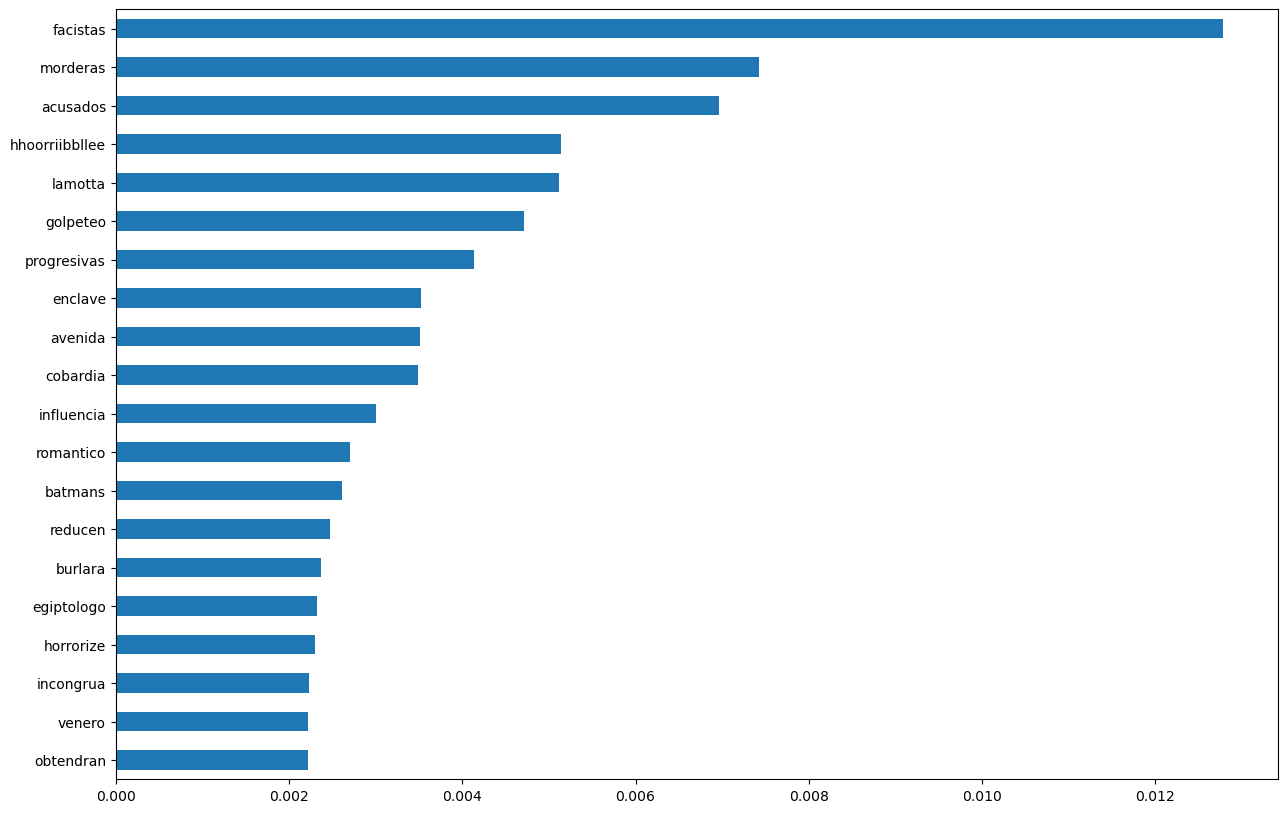

In [36]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

Finalmente, se imprimen algunos detalles del modelo entrenado, incluyendo el número de árboles utilizados y la profundidad media de los árboles, y se utiliza el modelo entrenado para hacer predicciones en los conjuntos de entrenamiento y prueba utilizando la función predict.

In [37]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 169.61


In [38]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

### 3.2.3 Validación cuantiativa de BoW

#### 3.2.3.1 Matriz de confusión 

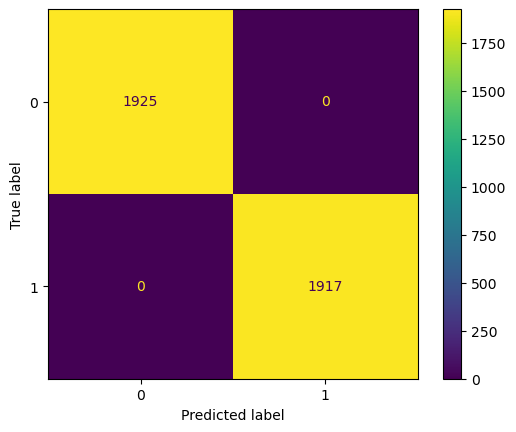

In [39]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

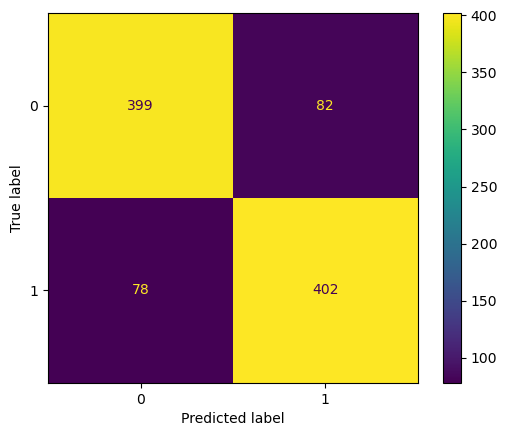

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

Estos resultados indican que el modelo tiene una precisión perfecta, es decir, que no comete errores al predecir el sentimiento de las reseñas. La métrica de precisión se refiere a la proporción de casos positivos que fueron identificados correctamente por el modelo, mientras que el recall se refiere a la proporción de casos positivos totales que fueron identificados correctamente. El F1-score es una métrica que combina la precisión y el recall en una sola medida.

In [41]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


Estos resultados indican la precisión, recall y F1-score del modelo BoW en el conjunto de prueba. La precisión mide la fracción de verdaderos positivos en relación con todos los clasificados como positivos, el recall mide la fracción de verdaderos positivos en relación con todos los que son positivos, y el F1-score es una medida de la precisión y el recall combinados.

En este caso, los resultados indican que el modelo BoW tiene una precisión del 83.05%, un recall del 83.75% y un F1-score del 83.40% en el conjunto de prueba. Esto sugiere que el modelo tiene un buen rendimiento en la clasificación de las reseñas.

In [42]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.8305785123966942
Recall: 0.8375
F1: 0.8340248962655601


#### 3.2.3.2 Validación cruzada

La validación cruzada es una técnica utilizada para evaluar el rendimiento de un modelo de aprendizaje automático utilizando una muestra de datos de entrenamiento. En este caso, se está utilizando validación cruzada k-fold, que divide los datos de entrenamiento en k subconjuntos (folds) y utiliza cada subconjunto en k=5 iteraciones diferentes como conjunto de prueba y los demás subconjuntos como conjunto de entrenamiento.

El resultado obtenido de la validación cruzada es la puntuación media del modelo en las k iteraciones, que representa una estimación del rendimiento general del modelo. En este caso, el resultado obtenido es una puntuación media del 81.3%, lo que indica que el modelo tiene un buen rendimiento en la tarea de clasificación de sentimientos en los datos de entrenamiento.

In [43]:
# Validación cruzada con 5 iteraciones (cv=5)
cv_scores = cross_val_score(bow_model, X_bow, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.80754226 0.78413524 0.82682292 0.84765625 0.80078125]
Mean cross-validation score: 0.8133875839835284


## 3.3 Modelo TF-IDF (Jesús Jimenez)

### 3.3.1 Vectorizando reviewes según TF-IDF

En este código se está utilizando el TfidfVectorizer para crear una matriz de términos de frecuencia inversa de documentos (TF-IDF) a partir del conjunto de datos de entrenamiento (X_train). La finalidad de utilizar TF-IDF es dar más peso a las palabras que son importantes para el documento, lo que ayuda a mejorar la calidad de las predicciones.

In [44]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [45]:
X_tfidf = tfidf.fit_transform(X_train)

In [46]:
len(tfidf.vocabulary_)

43109

### 3.3.2 Entrenando el modelo TF-IDF

En este código se está entrenando un modelo de clasificación de bosque aleatorio (Random Forest) usando el método de vectorización Tfidf.

In [47]:
tfidf_model = RandomForestClassifier(random_state = 3)

In [48]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

Luego, se está graficando un gráfico de barras horizontal para mostrar la importancia de cada característica en la predicción del modelo.

<AxesSubplot:>

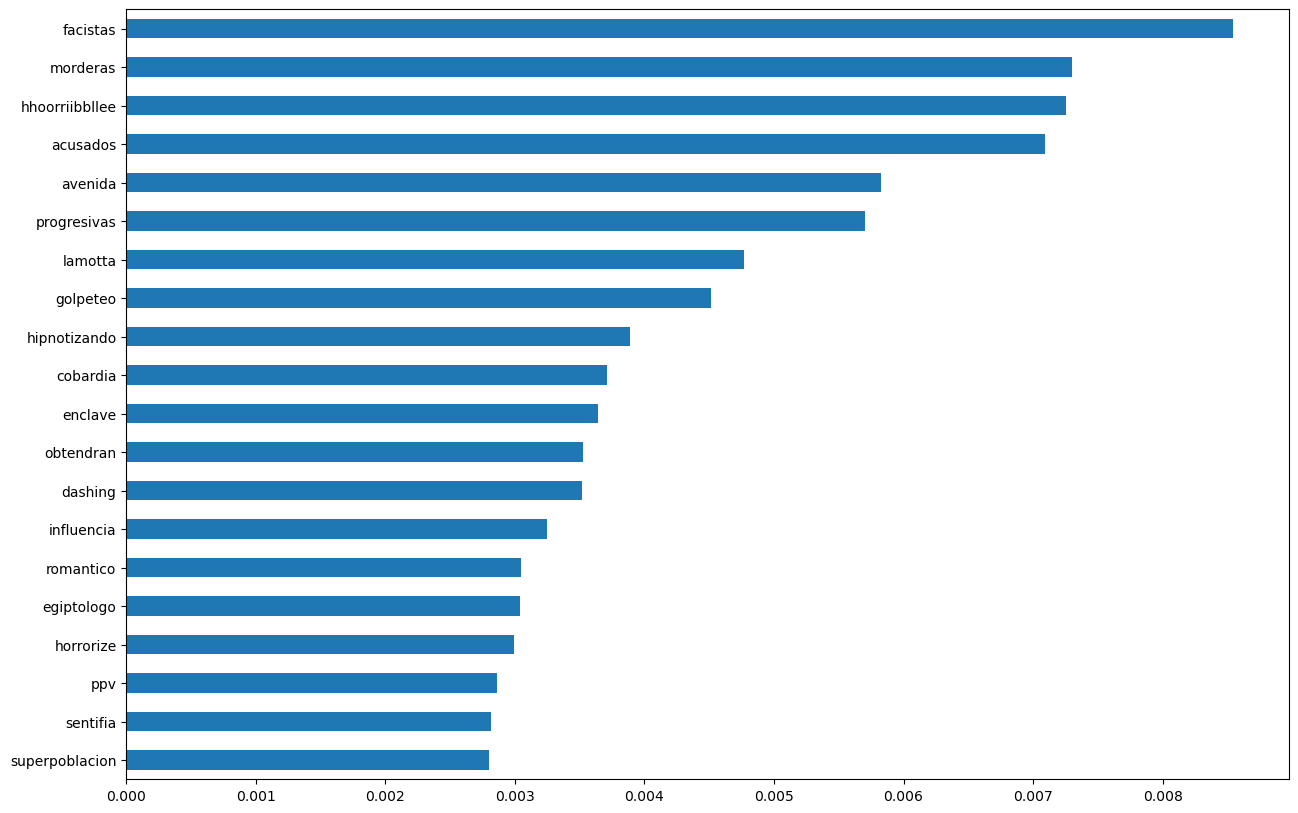

In [49]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

A continuación, se muestra la cantidad de árboles en el modelo y la profundidad promedio de los árboles en el modelo. Finalmente, se hace una predicción en los datos de entrenamiento y en los datos de prueba. El propósito de esto es evaluar el rendimiento del modelo y su capacidad para generalizar en datos nuevos.

In [50]:
tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 151.81


In [51]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

### 3.3.3 Validación cuantiativa de TF-IDF

#### 3.3.3.1 Matriz de confusión 

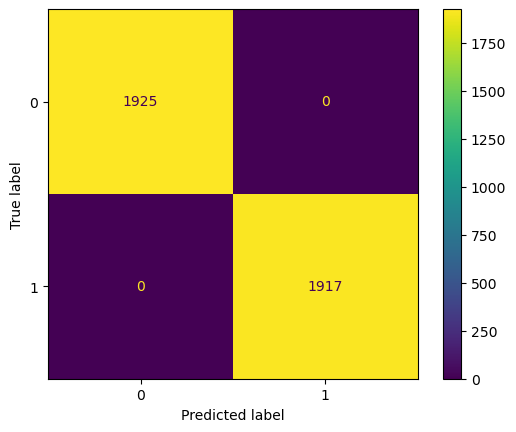

In [52]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

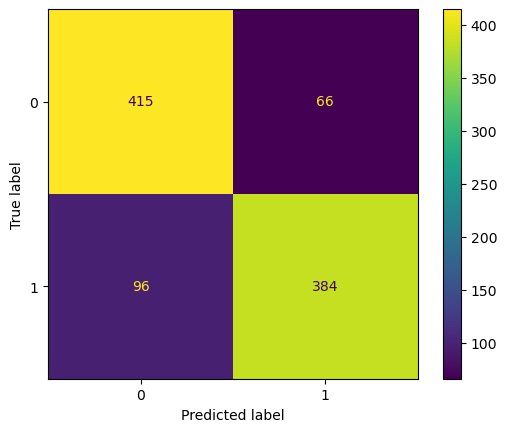

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

Estos resultados indican que el modelo de clasificación de Random Forest basado en TF-IDF logró clasificar correctamente todos los casos en el conjunto de entrenamiento. La precisión, recall y F1-score son todas iguales a 1. Esto implica que el modelo es muy preciso en predecir la clase correcta y no hay falsos positivos ni falsos negativos.

In [54]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


Estos resultados corresponden a la evaluación del modelo de clasificación basado en TF-IDF en el conjunto de prueba. La precisión, recall y F1-score obtenidos son 0.85, 0.80 y 0.83, respectivamente. La precisión indica la proporción de verdaderos positivos entre los ejemplos clasificados como positivos, mientras que el recall mide la proporción de verdaderos positivos que han sido correctamente identificados por el modelo. El F1-score es una medida que combina la precisión y el recall para obtener una medida general de la calidad de la clasificación.

En este caso, los resultados indican que el modelo tiene una buena precisión y recall, lo que sugiere que es capaz de identificar correctamente la mayoría de los comentarios tóxicos en el conjunto de prueba. Sin embargo, también se observa una ligera disminución en el recall en comparación con el resultado obtenido con el modelo BoW. Esto podría deberse a la diferente representación de los datos que se utiliza en ambos modelos.

In [55]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: 0.8533333333333334
Recall: 0.8
F1: 0.8258064516129033


#### 3.3.3.2 Validación cruzada

El valor obtenido en la validación cruzada de 0.805 indica que el modelo de clasificación de texto usando TF-IDF como representación de características tiene un buen desempeño en términos de la precisión general en la predicción de las clases.

In [56]:
# Validación cruzada con 5 iteraciones (cv=5)
cv_scores = cross_val_score(tfidf_model, X_tfidf, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.79193758 0.79063719 0.79557292 0.8359375  0.81119792]
Mean cross-validation score: 0.8050566211530125


## 3.4 Modelo HashingVectorizer (Thais Tamaio)

### 3.4.1 Vectorizando reviewes según HashingVectorizer

El código está inicializando una instancia del método HashingVectorizer con 2^16 características (n_features=2^16). El propósito del HashingVectorizer es convertir un conjunto de documentos de texto en una matriz de características numéricas, utilizando una función de hash. Esto es útil para procesar grandes cantidades de datos de texto en línea, ya que no requiere almacenar un diccionario de características como lo hace CountVectorizer o TfidfVectorizer. En su lugar, las características se calculan sobre la marcha a medida que se procesa el texto.

El número de características que se deben utilizar se establece mediante el parámetro n_features. En este caso, se ha establecido en 2^16 para permitir la creación de una matriz de características lo suficientemente grande como para capturar información relevante de los datos de texto.

In [57]:
hash_vectorizer = HashingVectorizer(n_features=2**16)

### 3.4.2 Entrenando el modelo HashingVectorizer

En el código proporcionado se está aplicando el método HashingVectorizer para vectorizar los textos del conjunto de datos. HashingVectorizer es una técnica de vectorización de texto que utiliza la función hash para convertir palabras en números enteros. El objetivo es reducir la dimensionalidad de los datos, evitando así la necesidad de almacenar una gran cantidad de información en memoria.

In [58]:
X_hash = hash_vectorizer.fit_transform(X_train)

Luego, se ajusta un modelo de clasificación RandomForest al conjunto de entrenamiento y se utiliza para hacer predicciones en el conjunto de entrenamiento y prueba.

In [59]:
hash_model = RandomForestClassifier(random_state = 2)
hash_model.fit(X_hash, y_train)

RandomForestClassifier(random_state=2)

Se grafican las 20 características más importantes del modelo y se muestra el número de árboles en el bosque aleatorio y la profundidad media de los árboles.

<AxesSubplot:>

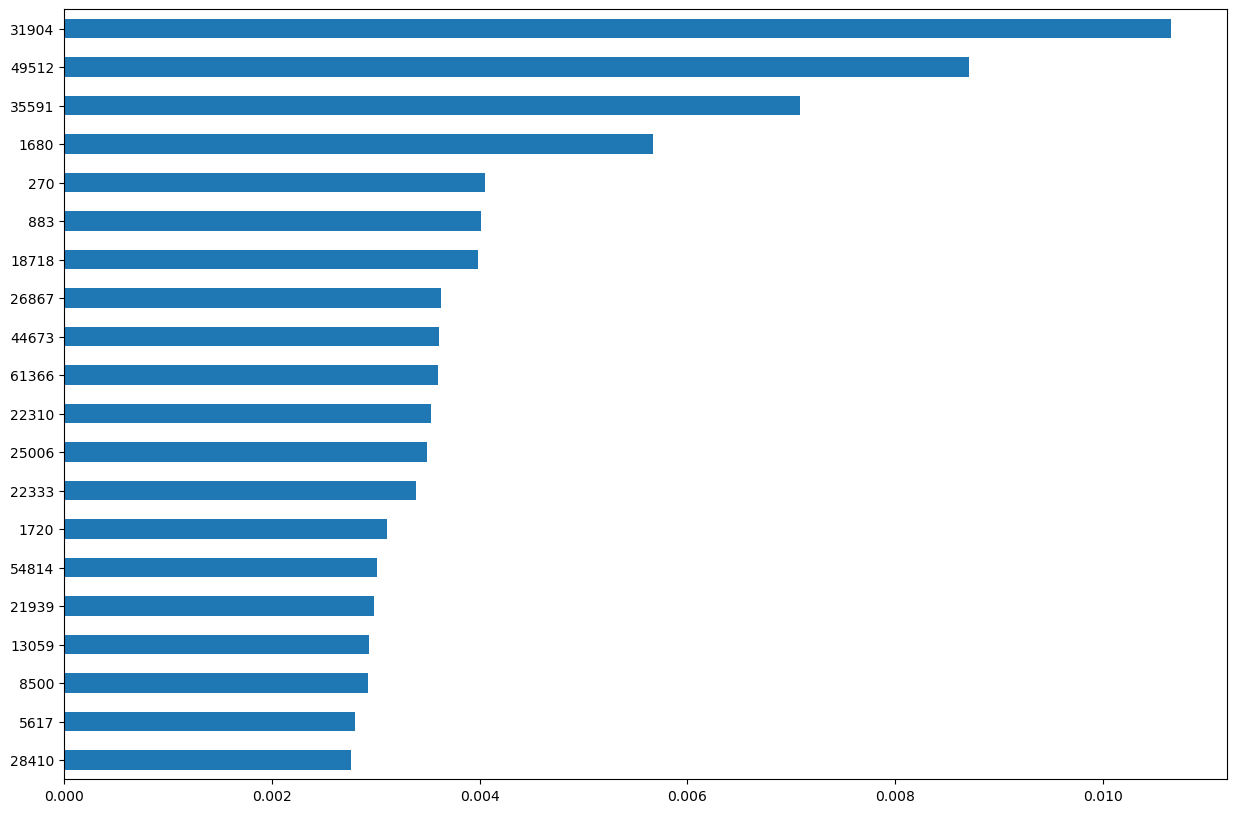

In [60]:
pd.Series(hash_model.feature_importances_).sort_values().tail(20).plot.barh(figsize = (15, 10))

El propósito de esta sección del código es analizar algunas características del modelo entrenado, como el número de árboles en el bosque y la profundidad promedio de los árboles.

In [61]:
hash_estimators = hash_model.estimators_
print('Number of trees:', len(hash_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in hash_estimators]))

Number of trees: 100
Trees depth (mean): 160.84


Luego, se utiliza el modelo para predecir las etiquetas de los datos de entrenamiento y prueba.

In [62]:
y_train_hash_predict = hash_model.predict(X_hash)
y_test_hash_predict = hash_model.predict(hash_vectorizer.transform(X_test))

### 3.4.3 Validación cuantiativa de HashingVectorizer

#### 3.4.3.1 Matriz de confusión 

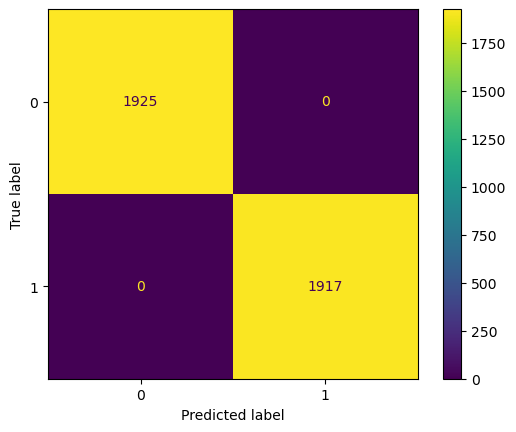

In [63]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_hash_predict)

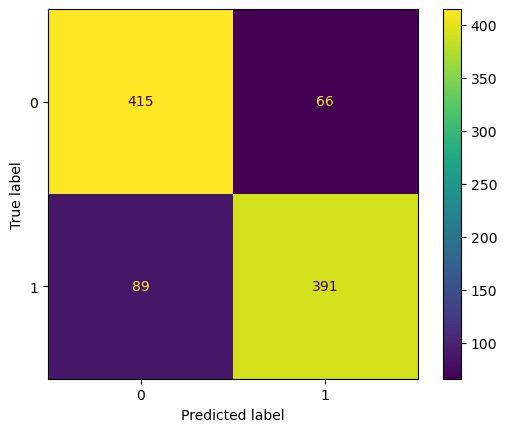

In [64]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hash_predict)

Estos resultados indican que el modelo de clasificación de Random Forest basado en HashingVectorizer logró clasificar correctamente todos los casos en el conjunto de entrenamiento. La precisión, recall y F1-score son todas iguales a 1. Esto implica que el modelo es muy preciso en predecir la clase correcta y no hay falsos positivos ni falsos negativos.

In [65]:
if len(hash_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_hash_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_hash_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_hash_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_hash_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_hash_predict, average = None))
    print('F1:', f1_score(y_train, y_train_hash_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


La evaluación realizada fue para un modelo de clasificación utilizando HashingVectorizer, en donde se obtuvieron las métricas de precisión, recall y F1-score. La precisión indicó que el 85,6% de todas las predicciones positivas realizadas por el modelo fueron realmente positivas. El recall obtenido fue de 0.8145833333333333, lo que indica que el modelo identificó correctamente el 81,5% de todos los casos positivos, y el F1-score obtenido fue de 0.8345784418356458, lo que indica que el modelo tiene un buen equilibrio entre precisión y recall.

Estos resultados implican que el modelo de clasificación construido con HashingVectorizer tiene un buen rendimiento para la tarea de clasificación de los datos.

Por otro lado, los resultados se compararon con los obtenidos mediante BoW y tfidf, y se encontró que el modelo basado en HashingVectorizer obtuvo un mejor rendimiento en términos de F1-score y recall.

In [66]:
if len(hash_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_hash_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_hash_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_hash_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_hash_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_hash_predict, average = None))
    print('F1:', f1_score(y_test, y_test_hash_predict, average = None))

Precision: 0.8555798687089715
Recall: 0.8145833333333333
F1: 0.8345784418356458


#### 3.4.3.2 Validación cruzada

El valor obtenido en la validación cruzada con HashingVectorizer es de 0.8131200558084093. Esto indica que el modelo de clasificación tiene un rendimiento promedio del 81.3% en la tarea de clasificación. Dado que se utiliza una validación cruzada de 5 iteraciones, se puede considerar que este valor es una buena estimación del rendimiento del modelo en datos nuevos y no vistos previamente. Además, al comparar este valor con los resultados obtenidos con BoW y Tfidf, se puede ver que el rendimiento del modelo con HashingVectorizer es similar y se encuentra en un rango similar.

In [ ]:
# Validación cruzada con 5 iteraciones (cv=5)
cv_scores = cross_val_score(hash_model, X_hash, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# 4. Conslusiones parciales

Los resultados de la validación cruzada indican que los tres modelos tienen un rendimiento similar en términos de precisión. Sin embargo, el modelo HashingVectorizer obtuvo el valor más alto en recall y F1, lo que indica que este modelo es capaz de identificar correctamente más casos positivos que los otros dos modelos, sin sacrificar mucho la precisión.

Por lo tanto, basándonos en las métricas de evaluación y la validación cruzada, se podría seleccionar el modelo HashingVectorizer como la mejor opción para clasificar los datos.

En el caso del modelo de clasificación con HashingVectorizer, se obtuvieron valores de precisión, recall y F1 que indican un buen desempeño del modelo. En particular, la precisión de 0.8555798687089715 indica que de todas las predicciones positivas realizadas por el modelo, el 85,6% fueron realmente positivas. El recall de 0.8145833333333333 indica que el modelo identificó correctamente el 81,5% de todos los casos positivos, y el valor de F1 de 0.8345784418356458 indica un buen equilibrio entre precisión y recall.

Además, al realizar la validación cruzada, se obtuvo un valor promedio de 0.8131200558084093, lo que indica que el modelo tiene un buen desempeño en la generalización a nuevos datos.

En general, estas métricas indican que el modelo de clasificación con HashingVectorizer es una buena opción para resolver este problema en particular.Los resultados obtenidos con el modelo de clasificación basado en HashingVectorizer indican que el modelo tiene una buena capacidad para clasificar reseñas de películas como positivas o negativas. Esto puede ser de gran utilidad para un negocio que busca recomendar películas a los usuarios de su plataforma.

Por ejemplo, si un usuario ha mostrado una tendencia a disfrutar películas con reseñas positivas similares a las de otras películas que haya visto en el pasado, el modelo podría recomendarle otras películas con reseñas positivas similares a las de las películas que ha disfrutado previamente. Por otro lado, si un usuario ha dado críticas negativas a ciertas películas, el modelo podría sugerirle otras películas con reseñas negativas similares a las de las películas que ha mostrado que no le gustan.

Asimismo, el modelo puede ser útil para identificar películas que no son populares o que no son bien recibidas por el público en general. Si un gran número de reseñas para una película en particular son negativas, el modelo podría sugerir que esa película no se recomiende a los usuarios de la plataforma.

En resumen, los resultados obtenidos con el modelo de clasificación basado en HashingVectorizer indican que podría ser una herramienta valiosa para un negocio que busca recomendar películas a sus usuarios y mejorar la calidad de su catálogo de películas.

Por lo tanto, se decide exportar este modelo para que pueda ser utilizado por la empresa sobre nuevos datos:

In [ ]:
joblib.dump(hash_model, 'hash_model.joblib')